# Jordan

In [1]:
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
fhs=glob.glob(r'D:\FAO\Jordan\Obs_data\NOAA_GHCN\monthly_csvs\*.csv')
output_folder=r'D:\FAO\WA_Sheet1\Main\Jordan\plot\precipitation_validation'
import os
os.chdir(r'D:\FAO\WA_Sheet1\WAPORWA')
import WaPOR
WaPOR.API.version=2

def Statistics(rs_m,obs_m):
    NSE=1-(np.sum((rs_m-obs_m)**2))/(np.sum((rs_m-np.mean(obs_m))**2))
    BIAS=np.sum(rs_m-obs_m)/np.sum(obs_m)
    RMSE=np.sqrt(np.average((rs_m-obs_m)**2))
    return (RMSE, NSE, BIAS)

def LinearRegression(x,y):
    # regression line
    #fitting RS and Observed data into a 1st order polynomial function (linear). z is the set of parameters of the fitted function
    z = np.polyfit(x, y, 1) 
    #define the fitted linear function using parameter as p(x) where x is observed value
    p = np.poly1d(z)
    function = "%.2f * x+ (%.2f)"%(z[0],z[1]) 
    return function,z,p

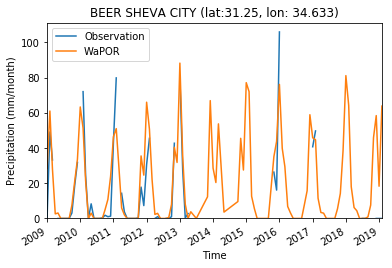

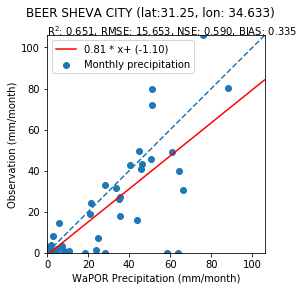

In [19]:
for fh in fhs[0:1]:
    #read observation data
    station=os.path.basename(fh).replace('.csv','')
    df=pd.read_csv(fh,sep=';')
    first_line=list(df.columns)
    lat=float(first_line[1])
    lon=float(first_line[3])
    start=df.iloc[0]['Lat:']
    end=df.iloc[-1]['Lat:']
    df.index=[datetime.datetime.strptime(i,'%Y-%m-%d') for i in df['Lat:']]
    df=df.rename(columns={'mm/month':'Observation'})
    df=df.replace(-9999,np.nan)
    #get WaPOR data
    df_wapor=WaPOR.API.getPixelTimeseries([lon,lat],cube_code='L1_PCP_M',
                                          time_range='{0},{1}'.format(start,end))   
    df_wapor.index=[datetime.datetime.strptime(i,'%Y-%m-%d') for i in df_wapor['month']]
    df_wapor=df_wapor.resample('MS').first()
    df_wapor=df_wapor.rename(columns={'value':'WaPOR'})
    #merge 2 timeseries
    df_merged=pd.merge(df,df_wapor,left_index=True,right_index=True,how='inner')
    df_P=df_merged.drop(columns=["Lat:","lon:",str(lon),str(lat),"month"])
    #save data
    df_P.to_csv(os.path.join(output_folder,'{0}.csv'.format(station)),sep=';')
    #plot timeseries
    df_P.plot(title='{0} (lat:{1}, lon: {2})'.format(station, lat,lon))
    plt.ylim(0)
    plt.ylabel('Precipitation (mm/month)')
    plt.xlabel('Time')
    plt.savefig(os.path.join(output_folder,'{0}.png'.format(station)),bbox_inches='tight')
    #plt.close()
    ###########################################################################
    #plot scatter
    df_notna=df_P.dropna()
    x=df_notna['WaPOR']
    y=df_notna['Observation']
    RMSE,NSE,BIAS=Statistics(x,y)
    function,z,p=LinearRegression(x,y)
    correlation = np.corrcoef(x, y)[0,1]
    r_squared=correlation**2
    axmax=max(max(x),max(y))
    fig,ax=plt.subplots()
    ax.scatter(x,y,label='Monthly precipitation')
    plt.plot([min(x),axmax],p([min(x),axmax]),"r",label=function)
    plt.plot([min(x),axmax],[min(x),axmax],"--")
    plt.text(0,1,'R$^2$: %.3f, RMSE: %.3f, NSE: %.3f, BIAS: %.3f'%(r_squared,RMSE,NSE,BIAS),transform=ax.transAxes)   
    plt.ylabel("Observation (mm/month)")
    plt.xlabel("WaPOR Precipitation (mm/month)")
    plt.legend()
    plt.ylim(0,axmax)
    plt.xlim(0,axmax)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.suptitle('{0} (lat:{1}, lon: {2})'.format(station, lat,lon))
    plt.savefig(os.path.join(output_folder,'{0}_scatter.png'.format(station)),bbox_inches='tight')
    #plt.close()

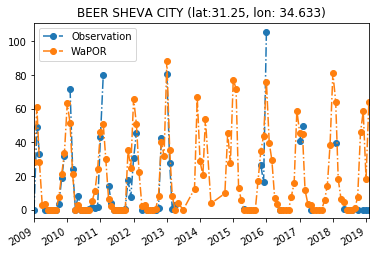

In [14]:
df_P.plot(title='{0} (lat:{1}, lon: {2})'.format(station, lat,lon),style='o-.')

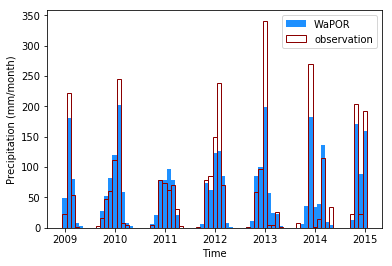

In [71]:
%matplotlib inline
x=np.arange(len(df_P.index))
plt.bar(x,df_P.WaPOR,label='WaPOR',color='dodgerblue',width=1)
plt.bar(x,df_P.Observation,label='observation',edgecolor='darkred',width=1,fill=False)
# plt.plot(x,df_P.Observation,'.',color='red',label='Observation')
ax=plt.gca()
ax.set_ylabel('Precipitation (mm/month)')
xticks=np.arange(0,len(df_P.index),12)
xticks_label=np.arange(2009,2019,1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_label)
ax.set_xlabel('Time')
plt.legend()

In [41]:
xticks=np.arange(0,len(df_P.index),12)
print(xticks)
xticks_label=np.arange(2009,2019,1)
print(xticks_label)

[  0  12  24  36  48  60  72  84  96 108]
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


In [21]:
# df_P.index=[y.year for y in df_P.index]
df_P

,Observation,WaPOR
2009-01-01,0.0,28.3
2009-02-01,49.1,61.0
2009-03-01,33.2,28.2
2009-04-01,NaN,2.6
2009-05-01,0.0,3.1
2009-06-01,0.0,0.0
2009-07-01,0.0,0.0
2009-08-01,0.0,0.0
2009-09-01,0.0,0.0
2009-10-01,3.1,7.5


### Plot rainfall bar charts

In [72]:
for fh in fhs:
    #read observation data
    station=os.path.basename(fh).replace('.csv','')
    df=pd.read_csv(fh,sep=';')
    first_line=list(df.columns)
    lat=float(first_line[1])
    lon=float(first_line[3])
    start=df.iloc[0]['Lat:']
    end=df.iloc[-1]['Lat:']
    
    df=df.rename(columns={'mm/month':'Observation'})
    df=df.replace(-9999,np.nan)
    #get WaPOR data
    df_wapor=WaPOR.API.getPixelTimeseries([lon,lat],cube_code='L1_PCP_M',
                                          time_range='{0},{1}'.format(start,end))   
    df_wapor.index=[datetime.datetime.strptime(i,'%Y-%m-%d') for i in df_wapor['month']]
    df_wapor=df_wapor.resample('MS').first()
    df_wapor=df_wapor.rename(columns={'value':'WaPOR'})
    #merge 2 timeseries
    df_merged=pd.merge(df,df_wapor,left_index=True,right_index=True,how='inner')
    df_P=df_merged.drop(columns=["Lat:","lon:",str(lon),str(lat),"month"])
    #save data
    df_P.to_csv(os.path.join(output_folder,'{0}.csv'.format(station)),sep=';')
    #plot timeseries
    x=np.arange(len(df_P.index))
#     plt.bar(x,df_P.WaPOR,label='WaPOR')
#     plt.plot(x,df_P.Observation,'.',color='red',label='Observation')
    plt.bar(x,df_P.WaPOR,label='WaPOR',color='dodgerblue',width=1)
    plt.bar(x,df_P.Observation,label='Observation',edgecolor='darkred',width=1,fill=False)
    ax=plt.gca()
    ax.set_ylabel('Precipitation (mm/month)')
    xticks=np.arange(0,len(df_P.index),12)
    xticks_label=np.arange(2009,2019,1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_label)
    ax.set_xlabel('Time')
    plt.legend()
    plt.suptitle('{0} (lat:{1}, lon: {2})'.format(station, lat,lon))
    plt.savefig(os.path.join(output_folder,'{0}.png'.format(station)),bbox_inches='tight')
    plt.close()
    plt.clf()
    ###########################################################################
    #plot scatter
    df_notna=df_P.dropna()
    x=df_notna['WaPOR']
    y=df_notna['Observation']
    RMSE,NSE,BIAS=Statistics(x,y)
    function,z,p=LinearRegression(x,y)
    correlation = np.corrcoef(x, y)[0,1]
    r_squared=correlation**2
    axmax=max(max(x),max(y))
    fig,ax=plt.subplots()
    ax.scatter(x,y,label='Monthly precipitation')
    plt.plot([min(x),axmax],p([min(x),axmax]),"r",label=function)
    plt.plot([min(x),axmax],[min(x),axmax],"--") #diagonal line
    plt.text(0,1,'R$^2$: %.3f, RMSE: %.3f, NSE: %.3f, BIAS: %.3f'%(r_squared,RMSE,NSE,BIAS),transform=ax.transAxes)   
    plt.ylabel("Observation (mm/month)")
    plt.xlabel("WaPOR Precipitation (mm/month)")
    plt.legend()
    plt.ylim(0,axmax)
    plt.xlim(0,axmax)    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.suptitle('{0} (lat:{1}, lon: {2})'.format(station, lat,lon))
    plt.savefig(os.path.join(output_folder,'{0}_scatter.png'.format(station)),bbox_inches='tight')
    plt.close()
    plt.clf()

<Figure size 432x288 with 0 Axes>